# Hyperparameter Optimization Pipeline
This notebook implements a staged approach to hyperparameter tuning for your CNN model:

1. Data & Training hyperparameters
2. Model-level hyperparameters
3. Regularization & augmentation
4. Scheduling & fine-tuning

## 1. Imports and Utility Functions

In [5]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader


from model_cnn import Model_CNN, sample_data

## 2. Load and Split Data

In [6]:
# Initialize model handler (adjust path & ranges)
data_path = '/Users/lauritsfauli/PycharmProjects/Final_project_APML/era5'
model = Model_CNN(data_path)
# Load raw data
print("Loading data without subsampling...")
model.load_data(sub_sampling=False)
model.prepare_data_for_tensorflow()

Loading data without subsampling...
Msl input shape: (1827, 120, 408)
input_file_names: ['era5_1940_mean_sea_level_pressure.nc', 'era5_1941_mean_sea_level_pressure.nc', 'era5_1942_mean_sea_level_pressure.nc', 'era5_1943_mean_sea_level_pressure.nc', 'era5_1944_mean_sea_level_pressure.nc']
T850 input shape: (1827, 120, 408)
input_file_names_t850: ['era5_1940_temperature_850hPa.nc', 'era5_1941_temperature_850hPa.nc', 'era5_1942_temperature_850hPa.nc', 'era5_1943_temperature_850hPa.nc', 'era5_1944_temperature_850hPa.nc']
Precipitation target shape: (1827,)
target_file_names: ['era5_1940_total_precipitation.nc', 'era5_1941_total_precipitation.nc', 'era5_1942_total_precipitation.nc', 'era5_1943_total_precipitation.nc', 'era5_1944_total_precipitation.nc']
No sub-sampling applied.
X shape: (1827, 2, 120, 408)
Precipitation target shape: (1827,)
X_train shape: (1577, 2, 120, 408)
y_train shape: (1577, 1)
X_test shape: (250, 2, 120, 408)
y_test shape: (250, 1)


## 3. Stage 1: Tune Learning Rate & Batch Size

Training with learning rate 0.0001...
Training with batch size 64...
Model summary: ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
FlexibleCNN                              [1, 1]                    --
├─Sequential: 1-1                        [1, 64, 7, 25]            --
│    └─Conv2d: 2-1                       [1, 32, 120, 408]         608
│    └─BatchNorm2d: 2-2                  [1, 32, 120, 408]         64
│    └─ReLU: 2-3                         [1, 32, 120, 408]         --
│    └─MaxPool2d: 2-4                    [1, 32, 30, 102]          --
│    └─Dropout2d: 2-5                    [1, 32, 30, 102]          --
│    └─Conv2d: 2-6                       [1, 64, 30, 102]          18,496
│    └─BatchNorm2d: 2-7                  [1, 64, 30, 102]          128
│    └─ReLU: 2-8                         [1, 64, 30, 102]          --
│    └─MaxPool2d: 2-9                    [1,

,lr,batch_size,val_loss
8,0.000070,256,0.029246
7,0.000070,128,0.030998
1,0.000100,128,0.031627
4,0.000085,128,0.033332
6,0.000070,64,0.034851


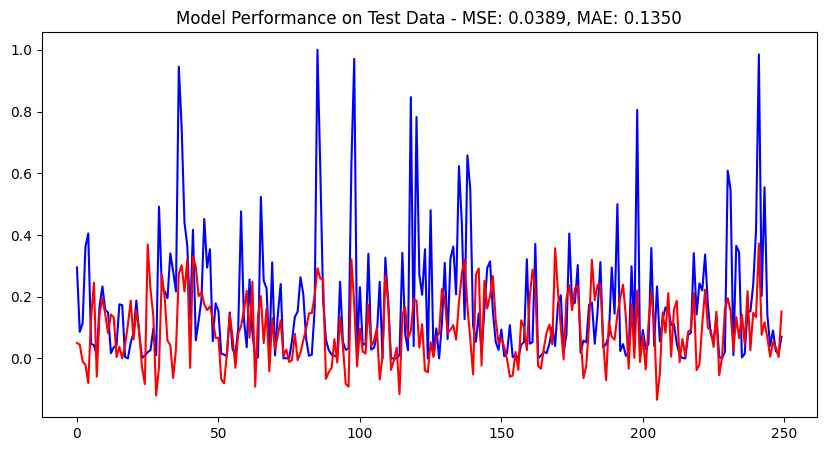

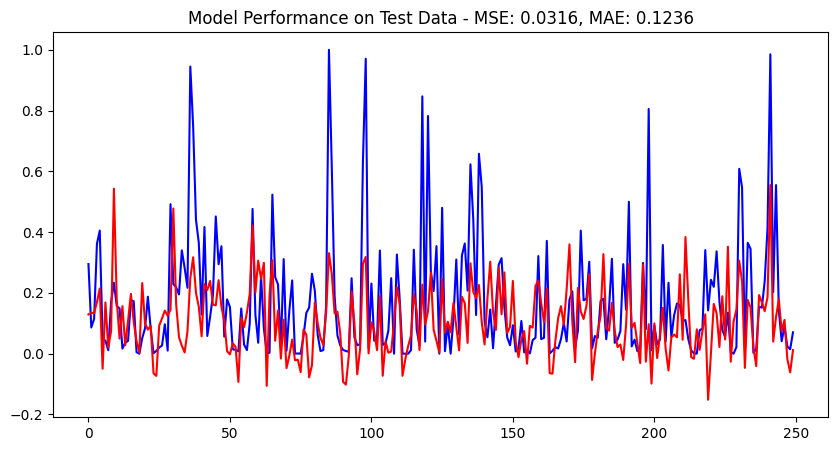

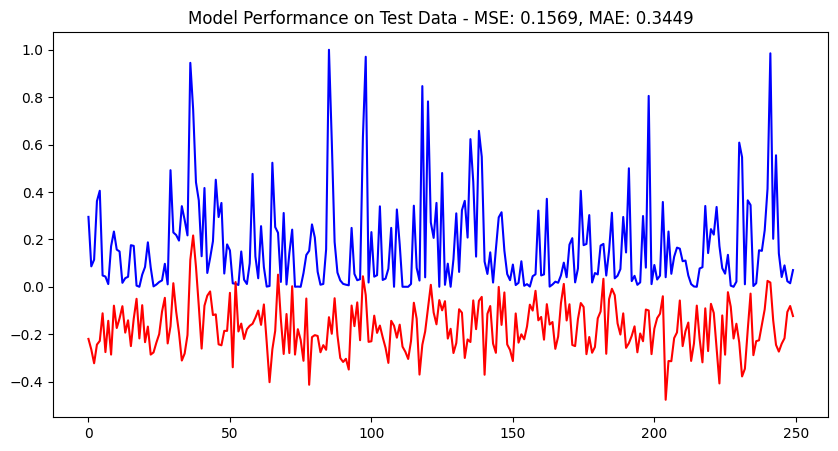

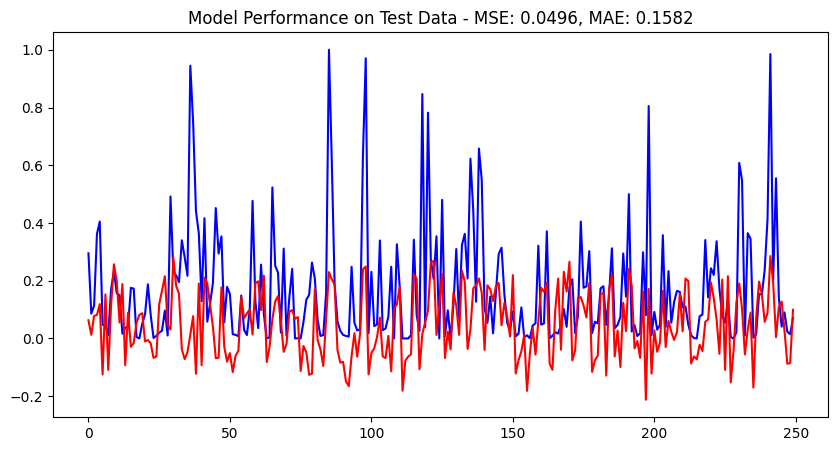

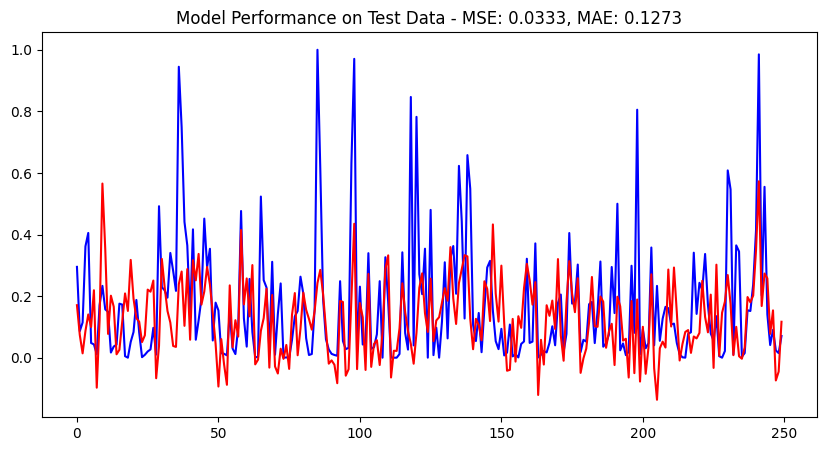

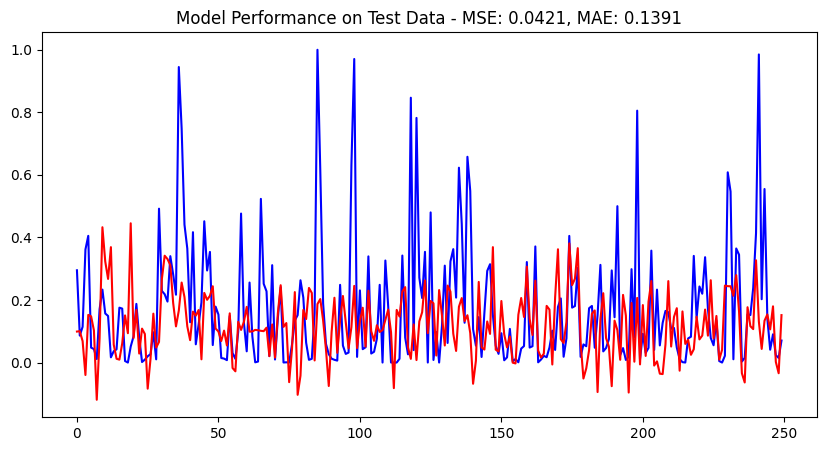

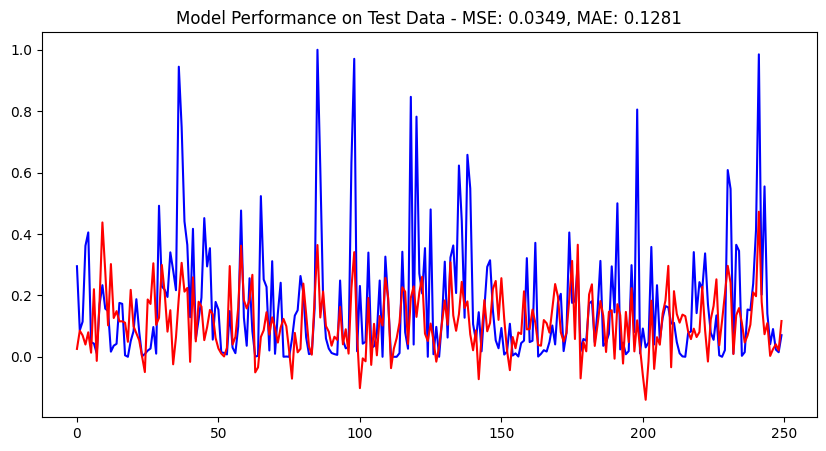

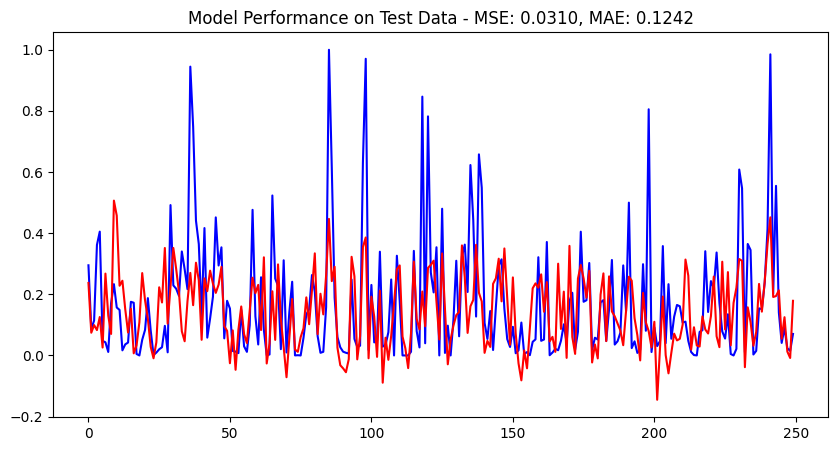

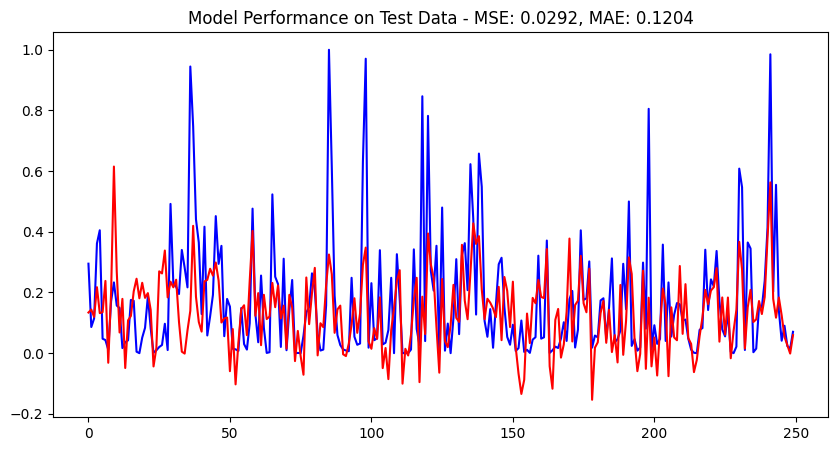

In [12]:
learning_rates = [0.85e-4]
batch_sizes = [16, 128, 256]
results_stage1 = []

for lr in learning_rates:
    print(f"Training with learning rate {lr}...")
    for bs in batch_sizes:
        print(f"Training with batch size {bs}...")

        # Build default model
        model.build_model(
            dropout_rate=0.2,
            conv_layers=[(32, 3, 4),(64, 3, 2),(64, 3, 2)],
            fc_layers=[128,64],

        )
        model.train_model(
            epochs=50,
            batch_size=bs,
            learning_rate=lr,
            validation_split=0.2,
            weight_decay=1e-5,
            patience=5,
            factor=0.5,
            early_stopping_patience=10,
            loss_function='MSE'
        )

        mse, mae = model.plot_model_on_test()

        results_stage1.append({'lr': lr, 'batch_size': bs, 'val_loss': mse})
        print(f"Validation loss for lr={lr}, bs={bs}: MSE: {mse:.2e}")

import pandas as pd
pd.DataFrame(results_stage1).sort_values('val_loss').head()

## 4. Stage 2: Tune Model Capacity (Depth & Width)

In [ ]:
depth_options = [2, 3, 4]  # number of conv blocks
base_options  = [16, 32]
results_stage2 = []
best_lr, best_bs = 3e-4, 32

for depth in depth_options:
    for base in base_options:
        conv_cfg = [(base * (2**i), 3, 2) for i in range(depth)]
        m.X, m.target = X_train, y_train
        m.prepare_data_for_tensorflow(test_size=0, sub_sampling=False, print_shapes=False)
        train_loader = DataLoader(m.dataset, batch_size=best_bs, shuffle=True)

        model = m.build_model(
            dropout_rate=0.2,
            conv_layers=conv_cfg,
            fc_layers=[256,128]
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
        val_loss = np.nan  # replace with actual
        results_stage2.append({'depth': depth, 'base': base, 'val_loss': val_loss})

pd.DataFrame(results_stage2).sort_values('val_loss').head()

## 5. Stage 3: Regularization (Dropout & Weight Decay)

In [ ]:
dropouts = [0.1, 0.2, 0.3]
decays   = [1e-4, 1e-5, 1e-6]
results_stage3 = []
best_arch = [(32,3,2),(64,3,2),(128,3,2)]
best_lr, best_bs = 3e-4, 32

for drop in dropouts:
    for wd in decays:
        m.X, m.target = X_train, y_train
        m.prepare_data_for_tensorflow(test_size=0, sub_sampling=False, print_shapes=False)
        train_loader = DataLoader(m.dataset, batch_size=best_bs, shuffle=True)

        model = m.build_model(
            dropout_rate=drop,
            conv_layers=best_arch,
            fc_layers=[256,128]
        )
        optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=wd)
        val_loss = np.nan  # replace with actual
        results_stage3.append({'dropout': drop, 'wd': wd, 'val_loss': val_loss})

pd.DataFrame(results_stage3).sort_values('val_loss').head()